In [1]:
import sys
import logging
from IPython.core.interactiveshell import InteractiveShell

# Cấu hình logging
logging.basicConfig(filename='training_output.log', level=logging.INFO, format='%(asctime)s - %(message)s')

# Bắt tất cả các output trong Jupyter
InteractiveShell.ast_node_interactivity = "all"

# Chuyển hướng stdout và stderr
class LogStream(object):
    def __init__(self, stream):
        self.stream = stream

    def write(self, message):
        if message.strip():  # Tránh ghi các dòng trống
            logging.info(message.strip())  # Ghi vào file log
            self.stream.write(message)  # In ra màn hình (notebook)

    def flush(self):
        self.stream.flush()


sys.stdout = LogStream(sys.__stdout__)
sys.stderr = LogStream(sys.__stderr__)

print("Start")


Start

2024-12-20 13:12:58.199921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734700378.214167      73 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734700378.218442      73 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 13:12:58.235354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1000

Premature end of JPEG file


Finished processing folder: 1Finished processing folder: 2Finished processing folder: 3Finished processing folder: 4Finished processing folder: 5Finished processing folder: 6Finished processing folder: 7Finished processing folder: 8Finished processing folder: 9Finished processing folder: 10Finished processing folder: 11Finished processing folder: 12Finished processing folder: 13Finished processing folder: 14Finished processing folder: 15Finished processing folder: 16Finished processing folder: 17Finished processing folder: 18Finished processing folder: 19Finished processing folder: 20Finished processing folder: 21Finished processing folder: 22Finished processing folder: 23Finished processing folder: 24Finished processing folder: 25Finished processing folder: 26Finished processing folder: 27Finished processing folder: 28Finished processing folder: 29Finished processing folder: 30Finished processing folder: 31Finished processing folder: 32Finished processing folder: 33Finished processing

Premature end of JPEG file
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


Finished processing folder: 267Finished processing folder: 268Finished processing folder: 269Finished processing folder: 270Finished processing folder: 271Finished processing folder: 272Finished processing folder: 273Finished processing folder: 274Finished processing folder: 275Finished processing folder: 276Finished processing folder: 277Finished processing folder: 278Finished processing folder: 279Finished processing folder: 280Finished processing folder: 281Finished processing folder: 282Finished processing folder: 283Finished processing folder: 284Finished processing folder: 285Finished processing folder: 286Finished processing folder: 287Finished processing folder: 288Finished processing folder: 289Finished processing folder: 290Finished processing folder: 291Finished processing folder: 292Finished processing folder: 293Finished processing folder: 294Finished processing folder: 295Finished processing folder: 296Finished processing folder: 297Finished processing folder: 298Finished

# IMPORT LIBRARY

In [2]:
# !pip install numpy matplotlib pillow torch tensorflow opencv-python scikit-learn torchvision

In [3]:
# !sudo apt-get update
# !sudo apt-get install libgl1-mesa-glx --yes

In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet18_Weights
import cv2
from sklearn.model_selection import train_test_split
import tarfile
import tqdm
import json


# DOWNLOAD IMAGENET (ILSVRC2011)

In [5]:
# !wget https://www.image-net.org/data/ILSVRC/2011/ILSVRC2011_images_train.tar

# EXTRACT DATA

In [6]:
# !mkdir train_data && tar -xvf ILSVRC2011_images_train.tar -C train_data && rm -f ILSVRC2011_images_train.tar

In [7]:
# import os
# import tarfile

# # Đặt thư mục gốc cần duyệt
# root_dir = 'train_data'  # Thay 'my_folder' bằng đường dẫn thư mục bạn muốn duyệt

# # Duyệt qua tất cả các tệp .tar trong thư mục đã chỉ định và các thư mục con
# for root, dirs, files in os.walk(root_dir):
#     for file in files:
#         if file.endswith('.tar'):
#             tar_path = os.path.join(root, file)
#             # Tạo thư mục với tên tệp không có phần mở rộng .tar
#             extract_dir = tar_path[:-4]  # Loại bỏ .tar khỏi tên tệp để tạo tên thư mục
#             os.makedirs(extract_dir, exist_ok=True)
            
#             # Giải nén tệp .tar vào thư mục mới
#             with tarfile.open(tar_path, 'r') as tar:
#                 tar.extractall(path=extract_dir)
            
#             # Xóa tệp .tar sau khi giải nén
#             os.remove(tar_path)
#             print(f"Đã giải nén và xóa tệp: {tar_path}")


In [8]:
sub_folder = os.listdir("train_data")
print(len(sub_folder))

# LOAD DATASET

In [9]:
import cv2
def read_image(file_path, target_size=(224, 224)):
    """
    Đọc ảnh từ file, tiền xử lý và trả về ma trận ảnh.
    
    Parameters:
    - file_path: Đường dẫn tới tệp ảnh.
    - target_size: Kích thước ảnh sau khi thay đổi kích thước (mặc định là 224x224).
    
    Returns:
    - ma trận ảnh đã được tiền xử lý hoặc None nếu không đọc được ảnh.
    """
    # Đọc ảnh từ file
    image = cv2.imread(file_path)
    
    # Nếu không thể đọc ảnh, trả về None
    if image is None:
        print(f"Không thể đọc ảnh từ tệp: {file_path}")  # In thông báo lỗi (tuỳ chọn)
        return None
    
    # Chuyển đổi ảnh từ BGR sang RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Thay đổi kích thước ảnh
    image = cv2.resize(image, target_size)
    
    # Chuẩn hóa ảnh
    image = image.astype(np.float32) / 255.0
    
    return image


In [10]:
# !pip install tqdm

In [11]:
import random
# Khởi tạo các biến
i = 0
map_label = {}
X_train = []
y_train = []

# Lấy danh sách các thư mục con trong thư mục train_data
sub_folder = os.listdir("train_data")

# Duyệt qua từng thư mục con trong train_data
for folder in sub_folder:
    folder_path = os.path.join("train_data", folder)
    
    # Kiểm tra xem có phải là thư mục không
    if os.path.isdir(folder_path):
        list_image_name = os.listdir(folder_path)
        
        selected_images = random.sample(list_image_name, int(0.4 * len(list_image_name)))
        
        # Gán nhãn cho từng thư mục
        map_label[folder] = i
        
        # Duyệt qua các tệp ảnh đã chọn
        for image_name in selected_images:
            full_path = os.path.join(folder_path, image_name)
            
            # Đọc ảnh và thêm vào X_train, y_train
            img = read_image(full_path)
            if img is not None:
                X_train.append(img)
                y_train.append(i)
        
        # In ra thông báo sau khi xử lý thành công thư mục
        print(f"Finished processing folder: {i+1}")
        
        # Tăng nhãn (i) sau khi xử lý một thư mục
        i += 1

# Chuyển X_train và y_train thành np.array
X_train = np.array(X_train)
y_train = np.array(y_train)

In [12]:
from torch.utils.data import DataLoader, TensorDataset

def create_data_loader(X_train, Y_train, batch_size=512, shuffle=True):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train, dtype=torch.int64)  
    
    X_train_tensor = X_train_tensor.permute(0, 3, 1, 2)  
    
    dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [14]:
print("X_train : {}".format(X_train.shape))
print("y_train : {}".format(y_train.shape))
print("X_val : {}".format(X_val.shape))
print("y_val : {}".format(y_val.shape))

In [15]:
val_loader = create_data_loader(X_val, y_val, batch_size=256)
del X_val, y_val
train_loader = create_data_loader(X_train, y_train, batch_size=256)
del X_train, y_train

In [16]:
# Hàm để in kích thước của data và label trong DataLoadeDr
def print_loader_shapes(data_loader, loader_name):
    print(f"\n{loader_name}:")

    for batch_idx, (data, labels) in enumerate(data_loader):
        print(f"  Batch {batch_idx + 1}:")
        print(f"    Data shape: {data.shape}")   # Kích thước của dữ liệu
        print(f"    Labels shape: {labels.shape}")  # Kích thước của nhãn
        break  # Dừng sau batch đầu tiên (nếu chỉ cần kiểm tra một batch)

# In kích thước của từng DataLoader
print_loader_shapes(train_loader, "Train Loader")
print_loader_shapes(val_loader, "val Loader")

In [17]:
device_count = torch.cuda.device_count()
print(f"Số GPU có sẵn: {device_count}")

# ADOPT

In [18]:
# ALGORITHM 2
# mypy: allow-untyped-decorators
# mypy: allow-untyped-defs
from typing import cast, Callable, List, Optional, Tuple, Union

import torch
from torch import Tensor

from torch.optim.optimizer import (
    _capturable_doc,
    _default_to_fused_or_foreach,
    _differentiable_doc,
    _disable_dynamo_if_unsupported,
    _foreach_doc,
    _fused_doc,
    _get_capturable_supported_devices,
    _get_scalar_dtype,
    _get_value,
    _maximize_doc,
    _stack_if_compiling,
    _use_grad_for_differentiable,
    _view_as_real,
    DeviceDict,
    Optimizer,
    ParamsT,
)


__all__ = ["ADOPT", "adopt"]


class ADOPT(Optimizer):
    def __init__(
        self,
        params: ParamsT,
        lr: Union[float, Tensor] = 1e-3,
        betas: Tuple[float, float] = (0.9, 0.9999),
        eps: float = 1e-6,
        clip_lambda: Optional[Callable[[int], float]] = lambda step: step**0.25,
        weight_decay: float = 0.0,
        decouple: bool = False,
        *,
        foreach: Optional[bool] = None,
        maximize: bool = False,
        capturable: bool = False,
        differentiable: bool = False,
        fused: Optional[bool] = None,
    ):
        if isinstance(lr, Tensor):
            if foreach and not capturable:
                raise ValueError(
                    "lr as a Tensor is not supported for capturable=False and foreach=True"
                )
            if lr.numel() != 1:
                raise ValueError("Tensor lr must be 1-element")
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= weight_decay:
            raise ValueError(f"Invalid weight_decay value: {weight_decay}")

        self.clip_lambda = clip_lambda

        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            decouple=decouple,
            maximize=maximize,
            foreach=foreach,
            capturable=capturable,
            differentiable=differentiable,
            fused=fused,
        )
        super().__init__(params, defaults)

        if fused:
            # TODO: support fused
            raise RuntimeError("`fused` is not currently supported")

            if differentiable:
                raise RuntimeError("`fused` does not support `differentiable`")
            self._step_supports_amp_scaling = True
            # TODO(crcrpar): [low prec params & their higher prec copy]
            # Support AMP with FP16/BF16 model params which would need
            # higher prec copy of params to do update math in higher prec to
            # alleviate the loss of information.
            if foreach:
                raise RuntimeError("`fused` and `foreach` cannot be `True` together.")

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault("maximize", False)
            group.setdefault("foreach", None)
            group.setdefault("capturable", False)
            group.setdefault("differentiable", False)
            fused = group.setdefault("fused", None)
            for p in group["params"]:
                p_state = self.state.get(p, [])
                if len(p_state) != 0 and not torch.is_tensor(p_state["step"]):
                    step_val = float(p_state["step"])
                    p_state["step"] = (
                        torch.tensor(
                            step_val,
                            dtype=_get_scalar_dtype(is_fused=fused),
                            device=p.device,
                        )
                        if group["capturable"] or group["fused"]
                        else torch.tensor(step_val, dtype=_get_scalar_dtype())
                    )

    def _init_group(
        self,
        group,
        params_with_grad,
        grads,
        exp_avgs,
        exp_avg_sqs,
        state_steps,
    ):
        has_complex = False
        for p in group["params"]:
            if p.grad is not None:
                has_complex |= torch.is_complex(p)
                params_with_grad.append(p)
                if p.grad.is_sparse:
                    raise RuntimeError(
                        "ADOPT does not support sparse gradients"
                    )
                grads.append(p.grad)

                state = self.state[p]
                # Lazy state initialization
                if len(state) == 0:
                    # if group["fused"]:
                    #     _device_dtype_check_for_fused(p)
                    # note(crcrpar): [special device hosting for step]
                    # Deliberately host `step` on CPU if both capturable and fused are off.
                    # This is because kernel launches are costly on CUDA and XLA.
                    state["step"] = (
                        torch.zeros(
                            (),
                            dtype=_get_scalar_dtype(is_fused=group["fused"]),
                            device=p.device,
                        )
                        if group["capturable"] or group["fused"]
                        else torch.tensor(0.0, dtype=_get_scalar_dtype())
                    )
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )
                    # Exponential moving average of squared gradient values
                    state["exp_avg_sq"] = torch.zeros_like(
                        p, memory_format=torch.preserve_format
                    )

                exp_avgs.append(state["exp_avg"])
                exp_avg_sqs.append(state["exp_avg_sq"])

                if group["differentiable"] and state["step"].requires_grad:
                    raise RuntimeError(
                        "`requires_grad` is not supported for `step` in differentiable mode"
                    )

                # Foreach without capturable does not support a tensor lr
                if (
                    group["foreach"]
                    and torch.is_tensor(group["lr"])
                    and not group["capturable"]
                ):
                    raise RuntimeError(
                        "lr as a Tensor is not supported for capturable=False and foreach=True"
                    )

                state_steps.append(state["step"])
        return has_complex

    @_use_grad_for_differentiable
    def step(self, closure=None):
        """Perform a single optimization step.

        Args:
            closure (Callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        self._cuda_graph_capture_health_check()

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad: List[Tensor] = []
            grads: List[Tensor] = []
            exp_avgs: List[Tensor] = []
            exp_avg_sqs: List[Tensor] = []
            state_steps: List[Tensor] = []
            beta1, beta2 = group["betas"]

            has_complex = self._init_group(
                group,
                params_with_grad,
                grads,
                exp_avgs,
                exp_avg_sqs,
                state_steps,
            )

            adopt(
                params_with_grad,
                grads,
                exp_avgs,
                exp_avg_sqs,
                state_steps,
                has_complex=has_complex,
                beta1=beta1,
                beta2=beta2,
                lr=group["lr"],
                clip_lambda=self.clip_lambda,
                weight_decay=group["weight_decay"],
                decouple=group["decouple"],
                eps=group["eps"],
                maximize=group["maximize"],
                foreach=group["foreach"],
                capturable=group["capturable"],
                differentiable=group["differentiable"],
                fused=group["fused"],
                grad_scale=getattr(self, "grad_scale", None),
                found_inf=getattr(self, "found_inf", None),
            )

        return loss


def _single_tensor_adopt(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    state_steps: List[Tensor],
    grad_scale: Optional[Tensor],
    found_inf: Optional[Tensor],
    *,
    has_complex: bool,
    beta1: float,
    beta2: float,
    lr: Union[float, Tensor],
    clip_lambda: Optional[Callable[[int], float]],
    weight_decay: float,
    decouple: bool,
    eps: float,
    maximize: bool,
    capturable: bool,
    differentiable: bool,
):
    assert grad_scale is None and found_inf is None

    if torch.jit.is_scripting():
        # this assert is due to JIT being dumb and not realizing that the ops below
        # have overloads to handle both float and Tensor lrs, so we just assert it's
        # a float since most people using JIT are using floats
        assert isinstance(lr, float)

    for i, param in enumerate(params):
        grad = grads[i] if not maximize else -grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step_t = state_steps[i]

        # If compiling, the compiler will handle cudagraph checks, see note [torch.compile x capturable]
        if not torch._utils.is_compiling() and capturable:
            capturable_supported_devices = _get_capturable_supported_devices()
            assert (
                param.device.type == step_t.device.type
                and param.device.type in capturable_supported_devices
            ), f"If capturable=True, params and state_steps must be on supported devices: {capturable_supported_devices}."

        step = step_t if capturable or differentiable else _get_value(step_t)

        if weight_decay != 0 and not decouple:
            grad = grad.add(param, alpha=weight_decay)

        if torch.is_complex(param):
            grad = torch.view_as_real(grad)
            if exp_avg is not None:
                exp_avg = torch.view_as_real(exp_avg)
            if exp_avg_sq is not None:
                exp_avg_sq = torch.view_as_real(exp_avg_sq)
            param = torch.view_as_real(param)

        if step == 0:
            exp_avg_sq.addcmul_(grad, grad.conj())
            # update step
            step_t += 1
            continue

        if weight_decay != 0 and decouple:
            param.add_(param, alpha=-lr*weight_decay)

        denom = torch.clamp(exp_avg_sq.sqrt(), eps)
        normed_grad = grad.div(denom)
        if clip_lambda is not None:
            clip = clip_lambda(step)
            normed_grad.clamp_(-clip, clip)

        exp_avg.lerp_(normed_grad, 1 - beta1)

        param.add_(exp_avg, alpha=-lr)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)

        # update step
        step_t += 1


def _multi_tensor_adopt(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    state_steps: List[Tensor],
    grad_scale: Optional[Tensor],
    found_inf: Optional[Tensor],
    *,
    has_complex: bool,
    beta1: float,
    beta2: float,
    lr: Union[float, Tensor],
    clip_lambda: Optional[Callable[[int], float]],
    weight_decay: float,
    decouple: bool,
    eps: float,
    maximize: bool,
    capturable: bool,
    differentiable: bool,
):
    if len(params) == 0:
        return

    if isinstance(lr, Tensor) and not capturable:
        raise RuntimeError(
            "lr as a Tensor is not supported for capturable=False and foreach=True"
        )

    # If compiling, the compiler will handle cudagraph checks, see note [torch.compile x capturable]
    if not torch._utils.is_compiling() and capturable:
        capturable_supported_devices = _get_capturable_supported_devices(
            supports_xla=False
        )
        assert all(
            p.device.type == step.device.type
            and p.device.type in capturable_supported_devices
            for p, step in zip(params, state_steps)
        ), f"If capturable=True, params and state_steps must be on supported devices: {capturable_supported_devices}."

    assert grad_scale is None and found_inf is None

    assert not differentiable, "_foreach ops don't support autograd"

    grouped_tensors = Optimizer._group_tensors_by_device_and_dtype(
        [params, grads, exp_avgs, exp_avg_sqs, state_steps]  # type: ignore[list-item]
    )
    for (
        device_params_,
        device_grads_,
        device_exp_avgs_,
        device_exp_avg_sqs_,
        device_state_steps_,
    ), _ in grouped_tensors.values():
        device_params = cast(List[Tensor], device_params_)
        device_grads = cast(List[Tensor], device_grads_)
        device_exp_avgs = cast(List[Tensor], device_exp_avgs_)
        device_exp_avg_sqs = cast(List[Tensor], device_exp_avg_sqs_)
        device_state_steps = cast(List[Tensor], device_state_steps_)

        # Handle complex parameters
        if has_complex:
            _view_as_real(
                device_params, device_grads, device_exp_avgs, device_exp_avg_sqs
            )

        if maximize:
            device_grads = torch._foreach_neg(device_grads)  # type: ignore[assignment]

        if weight_decay != 0 and not decouple:
            # Re-use the intermediate memory (device_grads) already allocated for maximize
            if maximize:
                torch._foreach_add_(device_grads, device_params, alpha=weight_decay)
            else:
                device_grads = torch._foreach_add(  # type: ignore[assignment]
                    device_grads, device_params, alpha=weight_decay
                )

        if device_state_steps[0] == 0:
            torch._foreach_addcmul_(device_exp_avg_sqs, device_grads, device_grads)

            # Update steps
            # If steps are on CPU, foreach will fall back to the slow path, which is a for-loop calling t.add(1) over
            # and over. 1 will then be wrapped into a Tensor over and over again, which is slower than if we just
            # wrapped it once now. The alpha is required to assure we go to the right overload.
            if not torch._utils.is_compiling() and device_state_steps[0].is_cpu:
                torch._foreach_add_(
                    device_state_steps, torch.tensor(1.0, device="cpu"), alpha=1.0
                )
            else:
                torch._foreach_add_(device_state_steps, 1)

            continue

        if weight_decay != 0 and decouple:
            torch._foreach_add_(device_params, device_params, alpha=-lr*weight_decay)

        exp_avg_sq_sqrt = torch._foreach_sqrt(device_exp_avg_sqs)
        torch._foreach_maximum_(exp_avg_sq_sqrt, eps)

        normed_grad = torch._foreach_div(device_grads, exp_avg_sq_sqrt)
        if clip_lambda is not None:
            clip = clip_lambda(device_state_steps[0])
            torch._foreach_maximum_(normed_grad, -clip)
            torch._foreach_minimum_(normed_grad, clip)

        torch._foreach_lerp_(device_exp_avgs, normed_grad, 1 - beta1)

        torch._foreach_add_(device_params, device_exp_avgs, alpha=-lr)
        torch._foreach_mul_(device_exp_avg_sqs, beta2)
        torch._foreach_addcmul_(
            device_exp_avg_sqs, device_grads, device_grads, value=1 - beta2
        )

        # Update steps
        # If steps are on CPU, foreach will fall back to the slow path, which is a for-loop calling t.add(1) over
        # and over. 1 will then be wrapped into a Tensor over and over again, which is slower than if we just
        # wrapped it once now. The alpha is required to assure we go to the right overload.
        if not torch._utils.is_compiling() and device_state_steps[0].is_cpu:
            torch._foreach_add_(
                device_state_steps, torch.tensor(1.0, device="cpu"), alpha=1.0
            )
        else:
            torch._foreach_add_(device_state_steps, 1)


def _fused_adopt(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    state_steps: List[Tensor],
    grad_scale: Optional[Tensor],
    found_inf: Optional[Tensor],
    *,
    has_complex: bool,  # Needed for consistency.
    beta1: float,
    beta2: float,
    lr: Union[float, Tensor],
    clip_lambda: Optional[Callable[[int], float]],
    weight_decay: float,
    decouple: bool,
    eps: float,
    maximize: bool,
    capturable: bool,  # Needed for consistency.
    differentiable: bool,
) -> None:
    raise NotImplementedError


@_disable_dynamo_if_unsupported(single_tensor_fn=_single_tensor_adopt)
def adopt(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    state_steps: List[Tensor],
    # kwonly args with defaults are not supported by functions compiled with torchscript issue #70627
    # setting this as kwarg for now as functional API is compiled by torch/distributed/optim
    foreach: Optional[bool] = None,
    capturable: bool = False,
    differentiable: bool = False,
    fused: Optional[bool] = None,
    grad_scale: Optional[Tensor] = None,
    found_inf: Optional[Tensor] = None,
    has_complex: bool = False,
    *,
    beta1: float,
    beta2: float,
    lr: Union[float, Tensor],
    clip_lambda: Optional[Callable[[int], float]],
    weight_decay: float,
    decouple: bool,
    eps: float,
    maximize: bool,
):
    r"""Functional API that performs ADOPT algorithm computation.

    """
    # Respect when the user inputs False/True for foreach or fused. We only want to change
    # the default when neither have been user-specified. Note that we default to foreach
    # and pass False to use_fused. This is not a mistake--we want to give the fused impl
    # bake-in time before making it the default, even if it is typically faster.
    if fused is None and foreach is None:
        _, foreach = _default_to_fused_or_foreach(
            params, differentiable, use_fused=False
        )
        # Do not flip on foreach for the unsupported case where lr is a Tensor and capturable=False.
        if foreach and isinstance(lr, Tensor) and not capturable:
            foreach = False
    if fused is None:
        fused = False
    if foreach is None:
        foreach = False

    # this check is slow during compilation, so we skip it
    # if it's strictly needed we can add this check back in dynamo
    if not torch._utils.is_compiling() and not all(
        isinstance(t, torch.Tensor) for t in state_steps
    ):
        raise RuntimeError(
            "API has changed, `state_steps` argument must contain a list of singleton tensors"
        )

    if foreach and torch.jit.is_scripting():
        raise RuntimeError("torch.jit.script not supported with foreach optimizers")
    if fused and torch.jit.is_scripting():
        raise RuntimeError("torch.jit.script not supported with fused optimizers")

    if fused and not torch.jit.is_scripting():
        func = _fused_adopt
    elif foreach and not torch.jit.is_scripting():
        func = _multi_tensor_adopt
    else:
        func = _single_tensor_adopt

    func(
        params,
        grads,
        exp_avgs,
        exp_avg_sqs,
        state_steps,
        has_complex=has_complex,
        beta1=beta1,
        beta2=beta2,
        lr=lr,
        clip_lambda=clip_lambda,
        weight_decay=weight_decay,
        decouple=decouple,
        eps=eps,
        maximize=maximize,
        capturable=capturable,
        differentiable=differentiable,
        grad_scale=grad_scale,
        found_inf=found_inf,
    )


# MODEL

In [19]:
from torch.optim import AdamW
from torchvision import models


class ModelTrain(nn.Module):
    def __init__(self, num_classes=1000):
        super(ModelTrain, self).__init__()
        self.model = models.resnet50(weights=None) 
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        # Forward pass through the ResNet-50 model
        return self.model(x)

    def fit(self, num_epochs, optimizer_type, train_loader, val_loader, base_lr=0.1, weight_decay=0.0001, scheduler=None, verbose=False):
        """
        Hàm huấn luyện mô hình.
        Args:
            num_epochs (int): Số epoch huấn luyện.
            optimizer_type (str): Loại optimizer ('AdamW', 'ADOPT', ...).
            train_loader (DataLoader): Bộ dữ liệu huấn luyện.
            val_loader (DataLoader): Bộ dữ liệu kiểm tra (validation).
            base_lr (float): Learning rate cơ bản.
            weight_decay (float): Hệ số weight decay cho optimizer.
            scheduler (torch.optim.lr_scheduler._LRScheduler): Lịch điều chỉnh learning rate (nếu có).
            verbose (bool): In thông tin chi tiết khi huấn luyện.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)  # Chuyển mô hình lên GPU nếu có

        # Chọn optimizer
        if optimizer_type == "AdamW":
            optimizer = AdamW(self.parameters(), lr=base_lr, weight_decay=weight_decay)
        elif optimizer_type == "ADOPT":
            optimizer = ADOPT(self.parameters(), lr=base_lr, decouple=True, weight_decay=weight_decay)

        history = {
            'step_loss': [],
            'step_accuracy': [],
            'step_val_accuracy': [],
            'epoch_loss': [],
            'epoch_accuracy': [],
            'val_accuracy': [],
        }

        iteration = 0
        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)  # Chuyển dữ liệu lên GPU
                iteration += 1

                # Cập nhật learning rate theo iteration
                lr = base_lr / (iteration ** 0.5)
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_train += (predicted == labels).sum().item()
                total_train += labels.size(0)

                step_loss = loss.item()
                step_accuracy = correct_train / total_train
                history['step_loss'].append(step_loss)
                history['step_accuracy'].append(step_accuracy)

                if verbose and ((i + 1) % 100 == 0):
                    print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], "
                          f"Loss: {step_loss:.6f}, Train Accuracy: {step_accuracy:.6f}, LR: {lr:.8f}")

            # Tổng hợp kết quả epoch
            epoch_loss = running_loss / len(train_loader)
            epoch_accuracy = correct_train / total_train
            history['epoch_loss'].append(epoch_loss)
            history['epoch_accuracy'].append(epoch_accuracy)

            # Đánh giá trên toàn bộ validation set
            val_accuracy = self._evaluate(val_loader, device)
            history['val_accuracy'].append(val_accuracy)

            if verbose:
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.6f}, "
                      f"Train Accuracy: {epoch_accuracy:.6f}, Validation Accuracy: {val_accuracy:.6f}")

        return history

    def _evaluate(self, data_loader, device):
        self.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

# TRAIN & SAVE MODEL

In [20]:
def train_and_save_model(optimizer_type, num_epochs, train_loader, val_loader, base_lr):
    # Khởi tạo mô hình
    model = ModelTrain()

    # Chuyển mô hình lên GPU nếu có
    if torch.cuda.is_available():
        print("Sử dụng 1 GPU!")
        model = model.cuda()

    # Huấn luyện mô hình với optimizer và thông số đã cho
    history = model.fit(
        num_epochs=num_epochs, 
        optimizer_type=optimizer_type, 
        train_loader=train_loader, 
        val_loader=val_loader, 
        base_lr=base_lr, 
        verbose=True
    )
    
    # Lưu kết quả huấn luyện vào dictionary
    result[optimizer_type] = history
    
    # Lưu trọng số mô hình đã huấn luyện vào file
    model_save_path = f"model_{optimizer_type}.pth"
    torch.save(model.state_dict(), model_save_path)

    return history

def save_training_history(result, file_path):
    # Lưu lịch sử huấn luyện dưới dạng file JSON
    with open(file_path, "w") as f:
        json.dump(result, f)

In [21]:
def plot_training_validation_accuracy(result, num_epochs, save_path=None):
    """
    Hàm vẽ biểu đồ so sánh độ chính xác huấn luyện và kiểm tra giữa các optimizer.

    Args:
        result (dict): Lịch sử huấn luyện của các optimizer, chứa các khóa là tên optimizer và giá trị là `history`.
        num_epochs (int): Số lượng epoch huấn luyện.
        save_path (str, optional): Đường dẫn nơi lưu ảnh. Nếu không có, chỉ hiển thị ảnh.
    """
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 6))

    for optimizer_type in result.keys():
        plt.plot(epochs, result[optimizer_type]['val_accuracy'], label=f'{optimizer_type} - Val Accuracy', linewidth=2)

    plt.ylim(0.5, 1.0)
    plt.title('Optimizer Comparison', fontsize=16)
    plt.xlabel('Epochs', fontsize=14, fontweight="bold")
    plt.ylabel('Validation Accuracy', fontsize=14, fontweight="bold")
    plt.legend(fontsize=12, loc='lower right')
    plt.grid(True)

    if save_path:
        plt.savefig(save_path)
        print(f"Biểu đồ đã được lưu tại: {save_path}")
    plt.show()

In [ ]:
# Danh sách các optimizers
list_optimizer = ["ADOPT", "AdamW"]  # Bạn có thể thêm các optimizer khác vào danh sách nếu cần
num_epochs = 50
result = {}
num_classes = 1000

# Huấn luyện mô hình với các optimizer trong danh sách
for optimizer_type in list_optimizer:
    history = train_and_save_model(
        optimizer_type=optimizer_type,
        num_epochs=num_epochs,
        train_loader=train_loader,
        val_loader=val_loader,
        base_lr= 0.1
    )

# Lưu toàn bộ lịch sử huấn luyện
history_save_path = "training_history.json"
save_training_history(result, history_save_path)


In [ ]:
# Lưu toàn bộ lịch sử huấn luyện
history_save_path = "training_history.json"
save_training_history(result, history_save_path)

In [1]:
import json

# Đường dẫn tới file JSON
file_path = 'training_history.json'

# Mở và đọc file JSON
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

# Hiển thị dữ liệu đã đọc
print(data)


{'ADOPT': {'step_loss': [7.003991603851318, 7.08584451675415, 19.243343353271484, 16.996610641479492, 14.159497261047363, 9.71517562866211, 8.569972038269043, 9.522834777832031, 8.446807861328125, 7.655335426330566, 7.306730270385742, 7.102251052856445, 6.972140789031982, 6.9333367347717285, 7.010083198547363, 7.001810073852539, 6.992640018463135, 6.941648006439209, 6.954082012176514, 6.967659950256348, 6.9204230308532715, 6.928069591522217, 6.904294013977051, 6.923848628997803, 6.904265880584717, 6.904321670532227, 6.919102191925049, 6.9196672439575195, 6.92940616607666, 6.903206825256348, 6.906586170196533, 6.9163970947265625, 6.897582054138184, 6.9026408195495605, 6.908757209777832, 6.892563819885254, 6.919570446014404, 6.909968376159668, 6.911362648010254, 6.931726932525635, 6.921292304992676, 6.8985466957092285, 6.939560890197754, 6.954926490783691, 6.924086093902588, 6.911855697631836, 6.927048683166504, 6.903841495513916, 6.928096294403076, 6.947555065155029, 6.918362617492676, 

In [30]:
adopt_val = data["ADOPT"]["val_accuracy"]
adamw_val = data["AdamW"]["val_accuracy"]

# VISUALIZE

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Validation Accuracy')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Validation Accuracy')

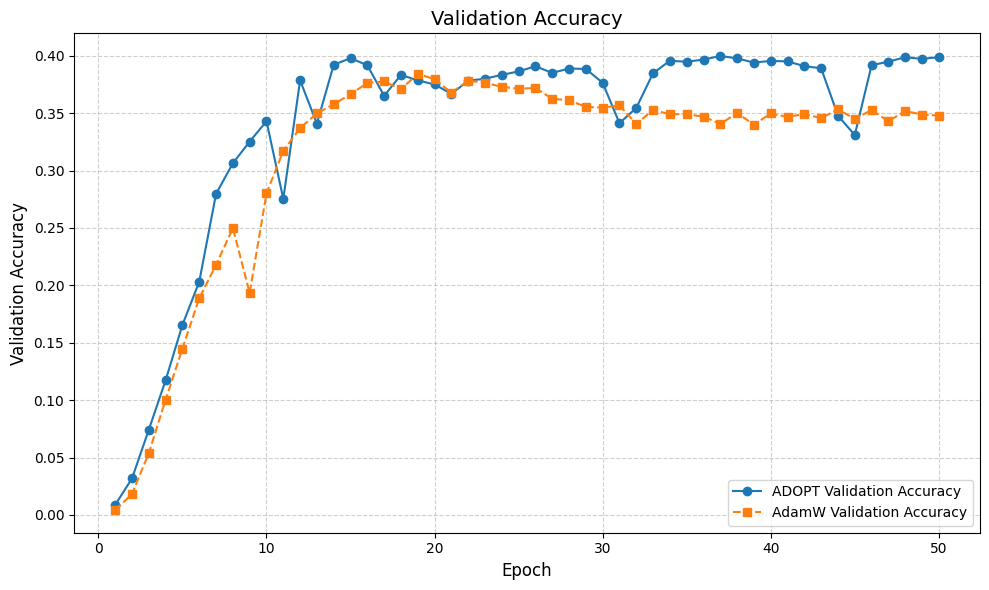

In [32]:
import matplotlib.pyplot as plt
import numpy as np
# Tạo danh sách các epoch từ 1 đến 50
epochs = np.arange(1, 51)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(epochs, adopt_val, label='ADOPT Validation Accuracy', marker='o', linestyle='-')
plt.plot(epochs, adamw_val, label='AdamW Validation Accuracy', marker='s', linestyle='--')

# Thêm tiêu đề, nhãn và chú thích
plt.title('Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

In [2]:
adopt_loss = data["ADOPT"]["epoch_loss"]
adamw_loss = data["AdamW"]["epoch_loss"]

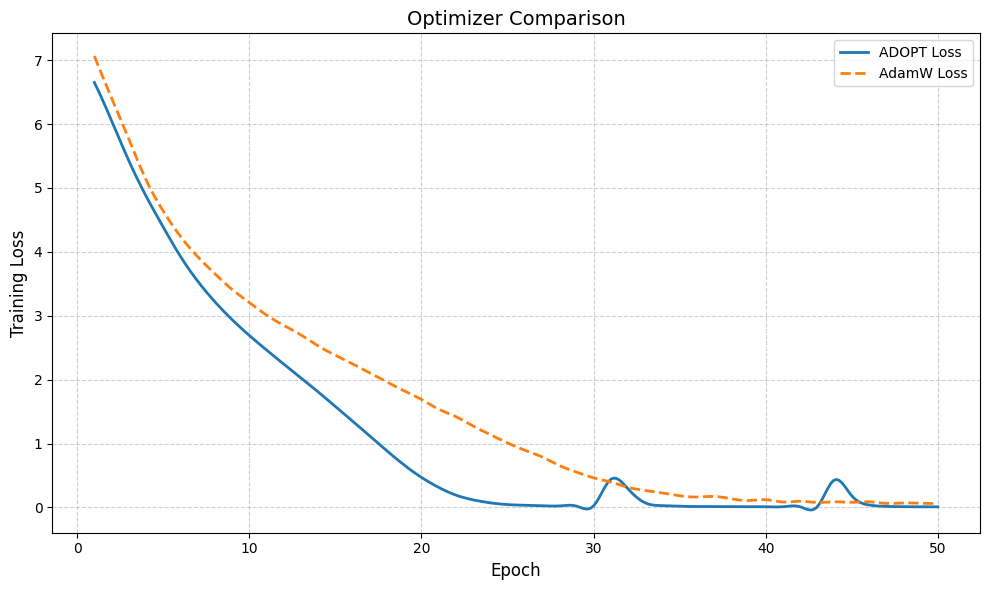

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

iteration = np.arange(1, len(adopt_loss) + 1)

iteration_smooth = np.linspace(iteration.min(), iteration.max(), 300)
adopt_loss_smooth = make_interp_spline(iteration, adopt_loss)(iteration_smooth)
adamw_loss_smooth = make_interp_spline(iteration, adamw_loss)(iteration_smooth)

plt.figure(figsize=(10, 6))

plt.plot(iteration_smooth, adopt_loss_smooth, label='ADOPT Loss', linestyle='-', linewidth=2)
plt.plot(iteration_smooth, adamw_loss_smooth, label='AdamW Loss', linestyle='--', linewidth=2)

plt.title('Optimizer Comparison', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()